In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from matplotlib.pyplot import imshow
from sklearn.metrics import f1_score

c:\Python310\lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.3)
  from scipy.sparse import csr_matrix, issparse


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

cpu


In [3]:
transform = transforms.Compose([ 
    transforms.Resize(size=(180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dir= "./data/train" # path to the train folder
validation_dir= "./data/validation" # path to the validation folder
test_dir = "./data/test" # path to test folder

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=transform) 

validation_data = datasets.ImageFolder(root=validation_dir, 
                                 transform=transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=transform)


print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3689
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 495
    Root location: ./data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 494
    Root location: ./data/test
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.

In [4]:
batch_size = 4
num_workers = 2

train_set = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=True) # dont usually need to shuffle validation data

test_set = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=num_workers, 
                             shuffle=True) # dont usually need to shuffle testing data

train_set,validation_set,test_set

(<torch.utils.data.dataloader.DataLoader at 0x211dce8ef50>,
 <torch.utils.data.dataloader.DataLoader at 0x211dce8d5a0>)

In [5]:
from models.modelv4 import SimpleCNN4
model = SimpleCNN4()

In [6]:
# I am going to add accuracies to these lists and I will use them outside of this function 
train_accuracies=[]
validation_accuracies=[]

# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    model.train()

    train_loss, correct = 0, 0
    

    for batch, (X, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device) 

        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # compute parameters gradients
        optimizer.step() # update parameters
        optimizer.zero_grad() #  reset the gradients of all parameters

        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            print(f'batch {batch} completed, train_loss={train_loss}')
    
    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size
    
    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

def validation(dataloader, model, loss_fn, t):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    validation_loss, correct = 0, 0
    
    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X) # make prediction
            validation_loss += loss_fn(pred, y).item() 
            
            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

### Layers 2-norm diff

In [15]:
def compute_l2_diff(param, init_param):
    """Compute L2 norm of the difference between current param and initial param."""
    return torch.norm(param - init_param)

epochs = 10

model = SimpleCNN4()

# Zachowujemy stan początkowy wszystkich wag (tzw. snapshot)
init_params = copy.deepcopy(model.state_dict())

# Słownik na listy z odległościami L2 (względem wag początkowych) dla każdej nazwy parametru
l2_diffs = {name: [] for name in model.state_dict().keys()}

# Listy na dokładność dla zbioru treningowego i testowego
train_accuracies = []
test_accuracies = []

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    print(f"\n=== EPOCH {epoch+1} / {epochs} ===")

    # ------ Training loop ------
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for X, y in train_set:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        correct += (pred.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_accuracy = 100.0 * correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for X, y in test_set:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_correct += (pred.argmax(dim=1) == y).sum().item()
            test_total += y.size(0)
    test_accuracy = 100.0 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    print(
        f"Train Accuracy: {train_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}%"
    )
    current_params = model.state_dict()
    for name in current_params.keys():
        # Skip any non-float parameters (like num_batches_tracked which is LongTensor)
        if current_params[name].dtype in (torch.float32, torch.float64):
            diff = compute_l2_diff(current_params[name], init_params[name])
            l2_diffs[name].append(diff.item())


=== EPOCH 1 / 10 ===
Train Accuracy: 69.15% | Test Accuracy: 69.43%

=== EPOCH 2 / 10 ===
Train Accuracy: 70.56% | Test Accuracy: 69.64%

=== EPOCH 3 / 10 ===
Train Accuracy: 73.03% | Test Accuracy: 81.17%

=== EPOCH 4 / 10 ===
Train Accuracy: 81.76% | Test Accuracy: 76.52%

=== EPOCH 5 / 10 ===
Train Accuracy: 85.90% | Test Accuracy: 91.70%

=== EPOCH 6 / 10 ===
Train Accuracy: 89.81% | Test Accuracy: 87.65%

=== EPOCH 7 / 10 ===
Train Accuracy: 92.27% | Test Accuracy: 89.27%

=== EPOCH 8 / 10 ===
Train Accuracy: 93.28% | Test Accuracy: 90.89%

=== EPOCH 9 / 10 ===
Train Accuracy: 94.82% | Test Accuracy: 95.14%

=== EPOCH 10 / 10 ===
Train Accuracy: 95.93% | Test Accuracy: 69.64%


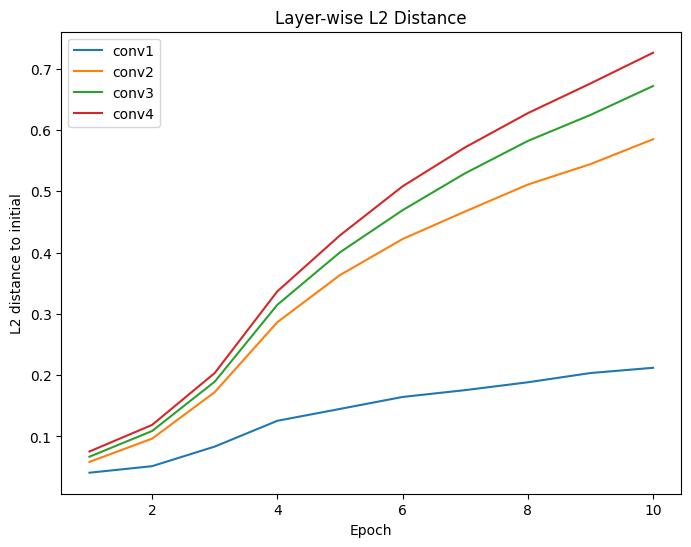

In [16]:
plt.figure(figsize=(8, 6))
epochs_range = range(1, epochs + 1)

for layer_name in ["conv1.weight", "conv2.weight", "conv3.weight", "conv4.weight"]:
    short_label = layer_name.replace(
        ".weight", ""
    )  # np. "conv1" zamiast "conv1.weight"
    plt.plot(epochs_range, l2_diffs[layer_name], label=short_label)

plt.xlabel("Epoch")
plt.ylabel("L2 distance to initial")
plt.title("Layer-wise L2 Distance")
plt.legend()
plt.show()

### Layers robustness

In [11]:
# We'll assume you have something like this:
# model = SimpleCNN4(num_classes=2).to(device)
# train_set, test_set = your DataLoaders


def measure_accuracy(model, data_loader, device):
    """Compute accuracy of the model on a given data_loader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total


def run_experiment(layer_name, mode, device, epochs=20, reinit_interval=1, lr=1e-3):
    """
    layer_name: e.g. 'conv1', 'conv2', ...
    mode: 'randomize' or 'reinit'
    epochs: total epochs to train
    reinit_interval: how often to 'mess up' the layer (e.g. every epoch)
    lr: learning rate
    """
    model = SimpleCNN4()
    init_params = copy.deepcopy(model.state_dict())

    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_accuracy_log = []
    val_accuracy_log = []
    test_accuracy_log = []

    for epoch in range(epochs):
        print(f"\n=== EPOCH {epoch+1} / {epochs} ===")
        # ---- Training loop ----
        model.train()
        for X, y in train_set:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

        # ---- Compute accuracy ----
        train_acc = measure_accuracy(model, train_set, device)
        val_acc = measure_accuracy(model, validation_set, device)
        test_acc = measure_accuracy(model, test_set, device)

        train_accuracy_log.append(train_acc)
        val_accuracy_log.append(val_acc)
        test_accuracy_log.append(test_acc)

        print(
            f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Test Acc: {test_acc:.2f}%"
        )

        # ---- "Mess up" the chosen layer if needed ----
        # We'll do it every "reinit_interval" epochs
        if (epoch + 1) % reinit_interval == 0:
            with torch.no_grad():
                if mode == "randomize":
                    print("\n Randomizing parameters...")
                    # Re-randomize the weights of the chosen layer
                    # Example for conv1: model.conv1.weight, model.conv1.bias
                    layer_weight = getattr(model, layer_name).weight
                    layer_bias = getattr(model, layer_name).bias
                    nn.init.xavier_uniform_(layer_weight)
                    nn.init.zeros_(layer_bias)
                elif mode == "reinit":
                    print("\n Reinitializing parameters...")
                    # Re-initialize the chosen layer to original weights
                    # We load from init_params dictionary
                    layer_weight = getattr(model, layer_name).weight
                    layer_bias = getattr(model, layer_name).bias
                    layer_weight.copy_(init_params[f"{layer_name}.weight"])
                    layer_bias.copy_(init_params[f"{layer_name}.bias"])
                else:
                    raise ValueError("Unknown mode! Choose 'randomize' or 'reinit'.")

    return train_accuracy_log, val_accuracy_log, test_accuracy_log

In [8]:
# We'll define the layers we want to test
layers_to_test = ["conv1", "conv2", "conv3", "conv4"]  # Example from SimpleCNN4
# layers_to_test = ["conv1", "conv2"]  # Example from SimpleCNN4
epochs = 10  # or 100 if you want a longer experiment
interval = 4

# We'll create dictionaries to store the results
re_randomize_results = {}
re_init_results = {}

for layer in layers_to_test:
    print(f"Running re-randomize experiment for {layer}...")
    re_randomize_results[layer] = run_experiment(
        layer, mode="randomize", device=device, epochs=epochs, reinit_interval=interval
    )

    print(f"Running re-init experiment for {layer}...")
    re_init_results[layer] = run_experiment(
        layer, mode="reinit", device=device, epochs=epochs, reinit_interval=interval
    )

Running re-randomize experiment for conv1...

=== EPOCH 1 / 10 ===
Train Accuracy: 69.43%

=== EPOCH 2 / 10 ===
Train Accuracy: 69.84%

=== EPOCH 3 / 10 ===
Train Accuracy: 37.65%

=== EPOCH 4 / 10 ===
Train Accuracy: 85.43%

 Randomizing parameters...

=== EPOCH 5 / 10 ===
Train Accuracy: 79.96%

=== EPOCH 6 / 10 ===
Train Accuracy: 86.44%

=== EPOCH 7 / 10 ===
Train Accuracy: 91.50%

=== EPOCH 8 / 10 ===
Train Accuracy: 90.69%

 Randomizing parameters...

=== EPOCH 9 / 10 ===
Train Accuracy: 87.25%

=== EPOCH 10 / 10 ===
Train Accuracy: 88.46%
Running re-init experiment for conv1...

=== EPOCH 1 / 10 ===
Train Accuracy: 69.43%

=== EPOCH 2 / 10 ===
Train Accuracy: 69.43%

=== EPOCH 3 / 10 ===
Train Accuracy: 70.65%

=== EPOCH 4 / 10 ===
Train Accuracy: 78.95%

 Reinitializing parameters...

=== EPOCH 5 / 10 ===
Train Accuracy: 77.13%

=== EPOCH 6 / 10 ===
Train Accuracy: 90.28%

=== EPOCH 7 / 10 ===
Train Accuracy: 83.40%

=== EPOCH 8 / 10 ===
Train Accuracy: 91.50%

 Reinitializing 

In [10]:
import json
all_results = {
    "re_randomize_results": re_randomize_results,
    "re_init_results": re_init_results,
}

with open("experiment_results.json", "w") as f:
    json.dump(all_results, f, indent=4)

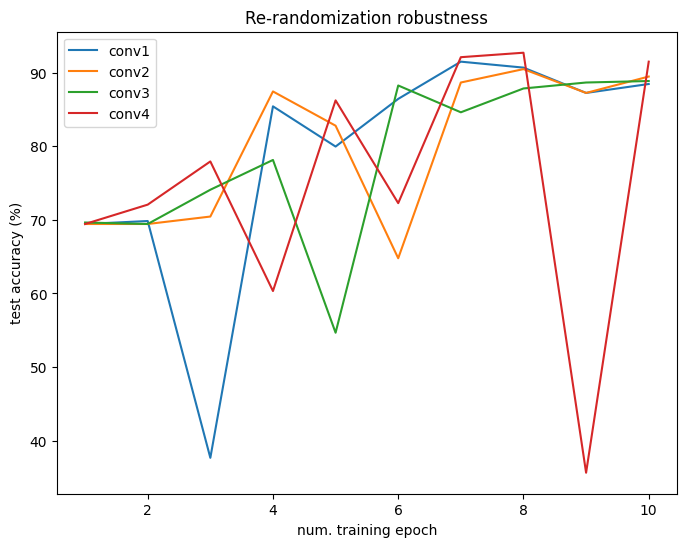

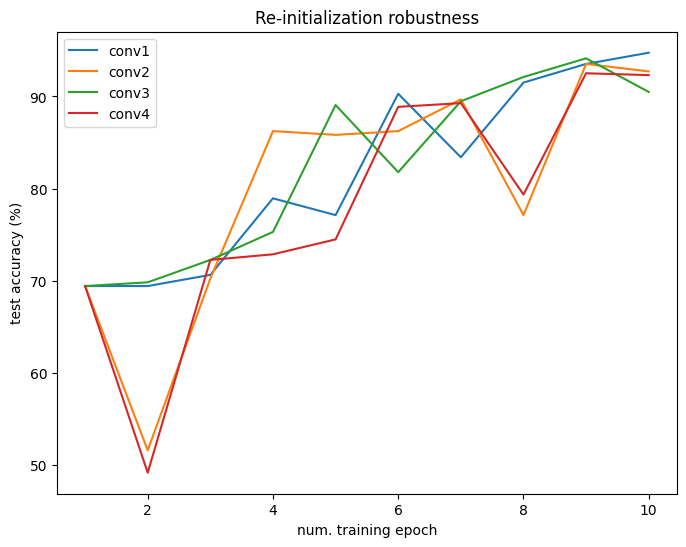

In [ ]:
# Now we can plot the results:
# 1) Re-randomization robustness
plt.figure(figsize=(8, 6))
for layer in layers_to_test:
    plt.plot(range(1, epochs + 1), re_randomize_results[layer], label=f"{layer}")
plt.xlabel("num. training epoch")
plt.ylabel("test accuracy (%)")
plt.title("Re-randomization robustness")
plt.legend()
plt.show()

# 2) Re-initialization robustness
plt.figure(figsize=(8, 6))
for layer in layers_to_test:
    plt.plot(range(1, epochs + 1), re_init_results[layer], label=f"{layer}")
plt.xlabel("num. training epoch")
plt.ylabel("test accuracy (%)")
plt.title("Re-initialization robustness")
plt.legend()
plt.show()